In [1]:
import numpy as np
import numpy.linalg as LA
from sklearn.utils import murmurhash3_32
from random import randint
import matplotlib.pyplot as plt
import stats
import copy
import time
import multiprocessing
from Functions import *
from scipy.special import factorial
import math
from scipy.stats import poisson
from scipy.stats import norm
from scipy.stats import binom
from scipy.integrate import quad
from scipy.stats import multivariate_normal
from scipy.stats import mvn
from scipy.optimize import fsolve
import sklearn.datasets as d

In [2]:
def hashfunc(m):
    ss = randint(1, 99999999)
    def hash_m(x):
        return murmurhash3_32(x,seed=ss)%m
    return hash_m


class count_sketch():
    def __init__(self, n, k):
        self.n = n
        self.k = k
        self.table = np.zeros((n,k))
        self.hash_func = [hashfunc(n) for i in range(int(k))]
        self.sign_hash = [hashfunc(2) for i in range(int(k))]
        self.item_count = 0
        
    def insert(self, item, index):
        loc = np.array([self.hash_func[k](index) for k in range(self.k)])
        sign = np.array([(-1)**(self.sign_hash[k](index)) for k in range(self.k)])
        self.table[loc,np.arange(self.k)] += item * sign
        self.item_count += 1
        
    def insert_ID_list(self, item, index):
        index = index.reshape((len(index), 1))
        loc_array = np.apply_along_axis(lambda x: [Hash(x[0]) for Hash in sketch.hash_func], 1, index)
        sign_array = np.apply_along_axis(lambda x: [(-1)**Hash(x[0]) for Hash in sketch.sign_hash], 1, index)
        for i in range(loc_array.shape[0]):      
            self.table[loc_array[i],np.arange(self.k)] += item[i] * sign_array[i]
        
    def retrieve(self, index):
        loc = np.array([self.hash_func[k](index) for k in range(self.k)])
        sign = np.array([(-1)**(self.sign_hash[k](index)) for k in range(self.k)])
        items = self.table[loc,np.arange(self.k)]*sign
        return np.median(items)
    
    def retrieve_ID_list(self, index):
        index = index.reshape((len(index), 1))
        loc_array = np.apply_along_axis(lambda x: [Hash(x[0]) for Hash in sketch.hash_func], 1, index)
        sign_array = np.apply_along_axis(lambda x: [(-1)**Hash(x[0]) for Hash in sketch.sign_hash], 1, index)
        item_array = self.table[loc_array.flatten(), np.tile(np.arange(self.k), loc_array.shape[0])]
        item_array = item_array.reshape(loc_array.shape) * sign_array
        return np.median(item_array, axis = 1)
    
    def retrieve_item_list(self, index, VAR = False):
        loc = np.array([self.hash_func[k](index) for k in range(self.k)])
        sign = np.array([(-1)**(self.sign_hash[k](index)) for k in range(self.k)])
        items = self.table[loc,np.arange(self.k)]*sign
        if VAR:
            item_var = np.var(np.sort(item_list)[3:(self.k-3)])
            return items, item_var
        else:
            return items
    
#     def retrieve_var(self, index):
#         loc = np.array([self.hash_func[k](index) for k in range(self.k)])
#         sign = np.array([(-1)**(self.sign_hash[k](index)) for k in range(self.k)])
#         items = self.table[loc,np.arange(self.k)]*sign
#         return np.var(items)
    
    def clean():
        self.table = np.zeros((n,k))
        self.item_count = 0
        
        
        
def parallel_apply_along_axis(func1d, axis, arr):
    """
    Like numpy.apply_along_axis(), but takes advantage of multiple
    cores.
    """        
    # Effective axis where apply_along_axis() will be applied by each
    # worker (any non-zero axis number would work, so as to allow the use
    # of `np.array_split()`, which is only done on axis 0):
    effective_axis = 1 if axis == 0 else axis
    if effective_axis != axis:
        arr = arr.swapaxes(axis, effective_axis)

    # Chunks for the mapping (only a few chunks):
    chunks = [(func1d, effective_axis, sub_arr)
              for sub_arr in np.array_split(arr, multiprocessing.cpu_count())]

    pool = multiprocessing.Pool()
    individual_results = pool.map(unpacking_apply_along_axis, chunks)
    # Freeing the workers:
    pool.close()
    pool.join()

    return np.concatenate(individual_results)



        
        
        
class count_sketch_power():
    def __init__(self, n, k, power):
        self.n = n
        self.k = k
        self.power = power
        self.table = np.zeros((n,k))
        self.hash_func = [hashfunc(n) for i in range(int(k))]
        self.sign_hash = [hashfunc(2) for i in range(int(k))]
        self.item_count = 0
        
    def insert(self, item, index):
        loc = np.array([self.hash_func[k](index) for k in range(self.k)])
        sign = np.array([(-1)**(self.sign_hash[k](index)) for k in range(self.k)])
        if np.abs(item) < 1:
            self.table[loc,np.arange(self.k)] += (item**(2*self.power)) * sign * np.sign(item)
        else:
            self.table[loc,np.arange(self.k)] += item * sign 
        self.item_count += 1
        
    def retrieve(self, index):
        loc = np.array([self.hash_func[k](index) for k in range(self.k)])
        sign = np.array([(-1)**(self.sign_hash[k](index)) for k in range(self.k)])
        items = self.table[loc,np.arange(self.k)]*sign
        item = np.median(items)
        if np.abs(item) < 1:
            item = np.sign(item)*(np.abs(item)**(0.5/self.power))
        return item
    
    def retrieve_item_list(self, index, VAR = False):
        loc = np.array([self.hash_func[k](index) for k in range(self.k)])
        sign = np.array([(-1)**(self.sign_hash[k](index)) for k in range(self.k)])
        items = self.table[loc,np.arange(self.k)]*sign
        item_list = []
        for item in items:
            if np.abs(item) < 1:
                item = np.sign(item)*(np.abs(item)**(0.5/self.power))
            item_list += [item]   
        if VAR:
            item_var = np.var(np.sort(item_list)[3:(self.k-3)])
            return item_list, item_var
        else:
            return item_list
    
#     def retrieve_var(self, index):
#         loc = np.array([self.hash_func[k](index) for k in range(self.k)])
#         sign = np.array([(-1)**(self.sign_hash[k](index)) for k in range(self.k)])
#         items = self.table[loc,np.arange(self.k)]*sign
#         return np.var(items)
    
    def clean():
        self.table = np.zeros((n,k))
        self.item_count = 0

        
        
class F2_count_sketch():
    def __init__(self, n, k, t):
        self.n = int(n)
        self.k = int(k)
        self.t = int(t)
        self.table = np.zeros((int(n),int(k*t)))
        self.hash_func = [hashfunc(n) for i in range(int(k))]
        self.sign_hash = [hashfunc(2) for i in range(int(k*t))]
        self.item_count = 0
        
    def insert(self, item, index):
        loc = np.array([self.hash_func[k](index) for k in range(self.k) for _ in range(self.t)])
        sign = np.array([(-1)**(self.sign_hash[k](index)) for k in range(self.k*self.t)])
        self.table[loc,np.arange(self.k*self.t)] += item * sign
        self.item_count += 1        
    
    def retrieve(self, index):
        loc = np.array([self.hash_func[k](index) for k in range(self.k) for _ in range(self.t)])
        sign = np.array([(-1)**(self.sign_hash[k](index)) for k in range(self.k*self.t)])
        items = self.table[loc,np.arange(self.k*self.t)]
        item_var = [0]*self.k
        for s in range(self.k):
            item_var[s] = np.mean(items[(s*self.t):((s+1)*self.t)]**2)
        return np.min(item_var)
    
    def clean():
        self.table = np.zeros((int(n),int(k*t)))
        self.item_count = 0

### Simulate data

In [3]:
p = 1000
n = 1800

mu = np.zeros(p)

w = np.zeros((p,p))
I = np.random.uniform(0,1,int(p*(p-1)/2))
# w[np.triu_indices(p, k=0)] = np.random.normal(0,0.02,int(p*(p+1)/2))*(I<0.9) + \
#                                 np.random.normal(0,1,int(p*(p+1)/2))*(I>=0.9)

w[np.triu_indices(p, k=1)] = np.random.uniform(0.5,1,int(p*(p-1)/2))*(I>=0.992) + \
                                np.random.uniform(-1,-0.5,int(p*(p-1)/2))*(I<=0.002)

var_diag = np.random.uniform(0, 0.1, p)
w = w + w.T + np.diag(var_diag)

S, V = LA.eig(w)
var = w - (min(S)-0.1)*np.diag(np.ones(p))

x = np.random.multivariate_normal(mu, var, (n))

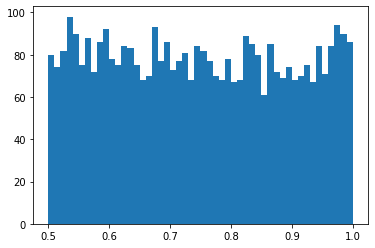

In [4]:
off_diag = var[np.triu_indices(p, k=1)]
plt.hist(off_diag[off_diag>0], bins=50)
plt.show()

In [6]:
# z = (x - mean_obs)

# c = []
# cor = []
# thres = 10

# for t in range(10000):
#     i = np.random.choice(np.arange(p))
#     j = np.random.choice(np.arange(p))
#     prod = z[:,i]*z[:,j]
#     c += [np.abs(np.sum((np.abs(prod)>thres)*(prod)))]
#     cor += [np.abs(var[i,j])]
    
    
# plt.scatter(cor, c, s=1)
# plt.show()

### Apply CMS to roughly select the non-zero covariance entries

In [5]:
mean_obs = np.apply_along_axis(np.mean, 0, x)
var_obs = (x - mean_obs).T@(x - mean_obs)/n
var_diag = np.diag(var_obs)

var_off_diag = var_obs[np.triu_indices(p, k=1)]
var_diag = np.diag(var_obs)

ID = [id(x) for x in var_off_diag]
ID = np.array([str(x) for x in ID])

In [13]:
block_end = list(np.arange(400, n, 100)) + [n]
block_start = [0] + block_end[:-1]

halflife = 400
weight = np.array(1**(np.arange(n)/halflife))
weight_sum = np.sum(weight)

sketch = count_sketch(p*20, 5)
sketch.clean

for i, (start, end) in enumerate(zip(block_start, block_end)):
    x_batch = x[start:end,:]
    mean_batch = np.apply_along_axis(np.mean, 0, x[0:end,:])
    var_batch = (x_batch - mean_batch).T@np.diag(weight[start:end])@ \
                (x_batch - mean_batch)/weight_sum
    var_off_diag_batch = var_batch[np.triu_indices(p, k=1)]
    
    ## Filtering
    if (i > 0):
        var_off_diag_batch = var_off_diag_batch[index_retain]
        ID_retain = np.array(ID)[index_retain]     
    else:
        index_retain = (np.ones(len(ID))>0)
        ID_retain = ID
    
    ## Insertion
    sketch.insert_ID_list(var_off_diag_batch, ID_retain)
#     for item, mem_id in zip(var_off_diag_batch, ID_retain):
#         sketch.insert(item, mem_id)
    
    ## Retrieve
    var_off_diag_2 = sketch.retrieve_ID_list(ID)
    
#     var_off_diag_2 = []
#     for mem_id in ID_retain:
#         var_off_diag_2 += [sketch.retrieve(mem_id)]
        
#     var_off_diag_prod_2 = []
#     var_off_diag_sign_2 = []
#     for mem_id in ID_retain:
#         item_list = np.sort(sketch.retrieve_item_list(mem_id))
#         var_off_diag_prod_2 += [np.prod(item_list[1:(sketch.k-1)])]
#         var_off_diag_sign_2 += [np.sum(np.sign(item_list))]
    
    
    thres_ratio = 0.5*2**(-(end - block_end[0])/halflife)
    median_entry = np.quantile(np.abs(var_off_diag_2), 1 - thres_ratio)
    index_retain = (np.abs(var_off_diag_2) > median_entry)
    
    print(round(median_entry, 5), np.sum(index_retain))

0.11337 249742
0.13049 210009
0.15095 176596
0.17361 148497
0.19675 124874
0.22096 105007
0.24688 88297
0.2737 74251
0.30494 62438
0.33487 52503
0.36701 44148
0.39901 37124
0.43334 31219
0.47166 26252
0.50869 22075


In [14]:
off_diag = var[np.triu_indices(p, k=1)]
# off_diag = off_diag[index_retain] 

F1_score = []
precision_list = []
recall_list = [] 


threshold_list = np.arange(0.3, 1, 0.01)
for thres in threshold_list:
    positive_index = (np.abs(off_diag)>0)
    predict_positive_index = (np.abs(var_off_diag_2)>thres)
    fn = np.sum(positive_index*(1-predict_positive_index))
    tp = np.sum(predict_positive_index*positive_index)
    
    precision = tp/np.sum(predict_positive_index)
    recall = tp/(tp+fn)
    
    ## Deviation from the true covariance matrix
    F1_score += [2*precision*recall/(precision+recall)]
    precision_list += [precision]
    recall_list += [recall]

Best F1 Score:  0.3694610078335087


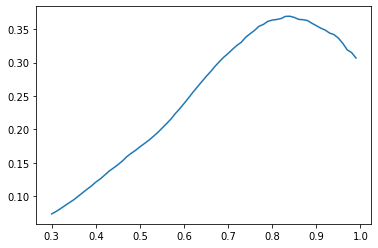

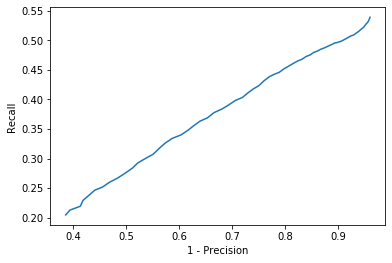

In [15]:
print('Best F1 Score: ', np.max(F1_score))

plt.plot(threshold_list, F1_score)
plt.show()

# plt.plot(threshold_list, precision_list)
# plt.show()

# plt.plot(threshold_list, recall_list)
# plt.show()

plt.plot(1 - np.array(precision_list), np.array(recall_list))
plt.xlabel('1 - Precision')
plt.ylabel('Recall')
plt.show()

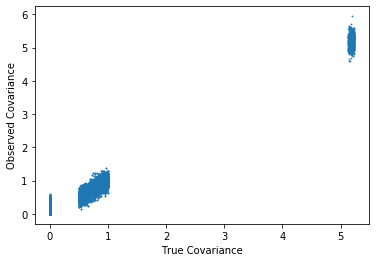

In [16]:
# plt.hist(np.sqrt(np.abs(var.flatten())), bins = 50)
# plt.title('Distribution of the true covariance entries')
# plt.show()

# plt.hist(np.abs(var_obs.flatten()), bins = 50)
# plt.title('Distribution of the sample covariance entries')
# plt.show()

plt.scatter(np.abs(var.flatten()), np.abs(var_obs.flatten()), s = 0.6)
plt.xlabel('True Covariance')
plt.ylabel('Observed Covariance')
plt.show()

### Apply CMS to approximate covariance matrix

In [128]:
sketch = count_sketch(p*20, 5)

sketch.clean
for item, mem_id in zip(var_off_diag, ID):
    sketch.insert(item, mem_id)

var_off_diag_2 = []
CMS_var = []
for mem_id in ID:
    var_off_diag_2 += [sketch.retrieve(mem_id)]
    
var_off_diag_prod_2 = []
var_off_diag_sign_2 = []
for mem_id in ID:
    item_list = np.sort(sketch.retrieve_item_list(mem_id))
    var_off_diag_prod_2 += [np.prod(item_list[1:(sketch.k-1)])]
    var_off_diag_sign_2 += [np.sum(np.sign(item_list))]
    
    
index = np.triu_indices(p, k=1)

var_CMS = np.diag(var_diag)
var_CMS[index] = np.array(var_off_diag_2)

var_CMS = var_CMS.T + var_CMS -  np.diag(var_diag)

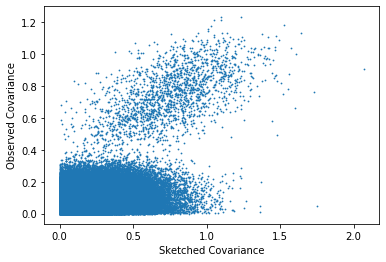

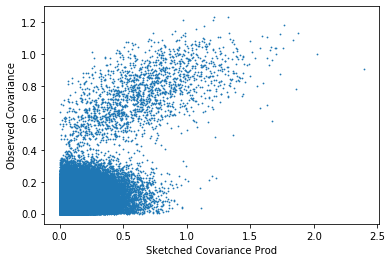

In [129]:
plt.scatter(np.abs(var_off_diag_2), np.abs(var_off_diag), s=0.6)
plt.ylabel('Observed Covariance')
plt.xlabel('Sketched Covariance')
plt.show()


plt.scatter(np.sqrt(np.abs(var_off_diag_prod_2)), np.abs(var_off_diag), s=0.6)
plt.ylabel('Observed Covariance')
plt.xlabel('Sketched Covariance Prod')
plt.show()

Best F1 Score:  0.5155776123518059


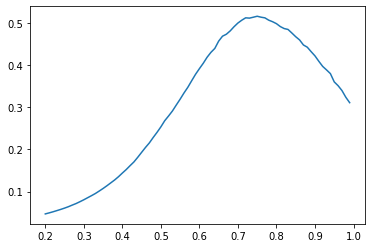

In [130]:
off_diag = var[np.triu_indices(p, k=1)]

F1_score = []
precision_list = []
recall_list = []
    
threshold_list = np.arange(0.2, 1, 0.01)
for thres in threshold_list:
    positive_index = (np.abs(off_diag)>0)*1
    predict_positive_index = (np.abs(var_off_diag_2)>thres)
    fn = np.sum(positive_index*(1-predict_positive_index))
    tp = np.sum(predict_positive_index*positive_index)
    precision = tp/np.sum(predict_positive_index)
    recall = tp/(tp+fn)
    
    ## Deviation from the true covariance matrix
    F1_score += [2*precision*recall/(precision+recall)]
    precision_list += [precision]
    recall_list += [recall]

    
print('Best F1 Score: ', np.max(F1_score))
plt.plot(threshold_list, F1_score)
plt.show()

# plt.plot(threshold_list, precision_list)
# plt.show()

# plt.plot(threshold_list, recall_list)
# plt.show()

### Apply F2 CMS to approximate covariance matrix

In [20]:
sketch = F2_count_sketch(p*30, 3, 7)

sketch.clean
for item, mem_id in zip(var_off_diag, ID):
    sketch.insert(item, mem_id)

var_off_diag_2 = []
CMS_var = []
for mem_id in ID:
    var_off_diag_2 += [sketch.retrieve(mem_id)]
    
# var_off_diag_prod_2 = []
# var_off_diag_sign_2 = []
# for mem_id in ID: 
#     item_list = np.sort(sketch.retrieve_item_list(mem_id))
#     var_off_diag_prod_2 += [np.prod(item_list[1:(sketch.k-1)])]
#     var_off_diag_sign_2 += [np.sum(np.sign(item_list))]
    
    
# index = np.triu_indices(p, k=1)

# var_CMS = np.diag(var_diag)
# var_CMS[index] = np.array(var_off_diag_2)

# var_CMS = var_CMS.T + var_CMS -  np.diag(var_diag)

Best F1 Score:  0.7950772753291357


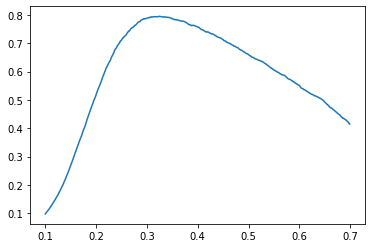

In [21]:
off_diag = var[np.triu_indices(p, k=1)]

F1_score = []
precision_list = []
recall_list = []
    
threshold_list = np.arange(0.1, 0.7, 0.001)
for thres in threshold_list:
    positive_index = (np.abs(off_diag)>0)*1
    predict_positive_index = (np.abs(var_off_diag_2)>thres)
    fn = np.sum(positive_index*(1-predict_positive_index))
    tp = np.sum(predict_positive_index*positive_index)
    precision = tp/np.sum(predict_positive_index)
    recall = tp/(tp+fn)
    
    ## Deviation from the true covariance matrix
    F1_score += [2*precision*recall/(precision+recall)]
    precision_list += [precision]
    recall_list += [recall]

    
print('Best F1 Score: ', np.max(F1_score))
plt.plot(threshold_list, F1_score)
plt.show()

# plt.plot(threshold_list, precision_list)
# plt.show()

# plt.plot(threshold_list, recall_list)
# plt.show()

In [17]:
# index_large = (np.abs(var_off_diag)>0.6)
# ID_large = np.array(ID)[index_large]
# var_off_diag_large = np.array(var_off_diag)[index_large]

# ss = np.random.choice(np.arange(len(ID_large)))
# print(var_off_diag_large[ss])
# item_list = sketch.retrieve_item_list(ID_large[ss])
# item_list = np.sort(item_list)
# print(item_list,  np.prod(item_list[1:(sketch.k-1)]))


# index_small = (np.abs(var_off_diag)<0.45)
# ID_small = np.array(ID)[index_small]
# var_off_diag_small = np.array(var_off_diag)[index_small]

# ss = np.random.choice(np.arange(len(ID_small)))
# print(var_off_diag_small[ss])
# item_list = sketch.retrieve_item_list(ID_small[ss])
# item_list = np.sort(item_list)
# print(item_list,  np.prod(item_list[1:(sketch.k-1)]))

In [35]:
# index_large = (np.abs(var_off_diag_2) > 0.6)

# plt.scatter(np.array(var_off_diag)[index_large],
#             np.array(var_off_diag_var_2)[index_large], s = 0.6)
# plt.show()

In [15]:
# power = 10
# sketch = count_sketch_power(p*15, 11, power)

# sketch.clean

# for item, mem_id in zip(var_off_diag, ID):
#     sketch.insert(item, mem_id)

# var_off_diag_2 = []
# CMS_var = []
# for mem_id in ID:
#     var_off_diag_2 += [sketch.retrieve(mem_id)]
    
# var_off_diag_var_2 = []
# for mem_id in ID:
#     item_list, item_var = sketch.retrieve_item_list(mem_id, VAR=True)
#     var_off_diag_var_2 += [item_var]
    
# index = np.triu_indices(p, k=1)

# # var_diag_power = (var_diag**(2*power))*np.sign(var_diag)
# var_CMS = np.diag(var_diag)
# var_CMS[index] = np.array(var_off_diag_2)

# var_CMS = var_CMS.T + var_CMS - np.diag(var_diag)

In [18]:
# plt.scatter(np.abs(var_off_diag), np.abs(var_off_diag_2), s=1)
# plt.xlabel('Absolute Observed Covariance')
# plt.ylabel('Absolute Sketched Covariance')
# plt.show()


# plt.scatter(var_off_diag, var_off_diag_2, s=1)
# plt.xlabel('Observed Covariance')
# plt.ylabel('Sketched Covariance')
# plt.show()

In [19]:
# index_large = (np.abs(var_off_diag_2) > 0.55)

# plt.scatter(np.array(var_off_diag)[index_large],
#             np.array(var_off_diag_var_2)[index_large], s = 0.6)
# plt.xlabel('Off Diagonal Entries')
# plt.ylabel('Variance of CMS estimate')
# plt.show()

In [41]:
# index_large = (np.abs(var_off_diag)>0.55)*(np.abs(var_off_diag)>0.55)
# ID_large = np.array(ID)[index_large]
# var_off_diag_large = np.array(var_off_diag)[index_large]

# ID_small = np.array(ID)[np.abs(var_off_diag) <0.6]
# var_off_diag_small = np.array(var_off_diag)[np.abs(var_off_diag) < 0.6]

# ss = np.random.choice(np.arange(len(ID_large)))
# print(var_off_diag_large[ss])
# item_list, item_var = sketch.retrieve_item_list(ID_large[ss], VAR=True)
# print(item_var)

# np.sort(item_list)

In [42]:
# index_confuse = (np.abs(var_off_diag)<0.45)*(np.abs(var_off_diag_2)>0.6)
# ID_confuse = np.array(ID)[index_confuse]
# var_off_diag_confuse = np.array(var_off_diag)[index_confuse]

# ss = np.random.choice(np.arange(len(ID_confuse)))
# print(var_off_diag_confuse[ss])
# item_list, item_var = sketch.retrieve_item_list(ID_confuse[ss], VAR=True)
# print(item_var)

# np.sort(item_list)


In [22]:
# threshold_list = np.arange(0.5, 1, 0.001)
# F1_score = []
# precision_list = []
# recall_list = [] 

# for thres in threshold_list:
#     ## Threshold the small entries of var_CMS
#     var_CMS_thres = copy.copy(var_CMS)
#     var_CMS_thres[np.abs(var_CMS_thres)<=thres] = 0
    
#     positive_index = (np.abs(var)>0)*1
#     predict_positive_index = (np.abs(var_CMS_thres)>0)*1
#     fn = np.sum(positive_index*(1-predict_positive_index))
#     tp = np.sum(predict_positive_index*positive_index)
#     precision = tp/np.sum(predict_positive_index)
#     recall = tp/(tp+fn)
    
#     ## Deviation from the true covariance matrix
#     F1_score += [2*precision*recall/(precision+recall)]
#     precision_list += [precision]
#     recall_list += [recall]

# max_F1 = np.max(F1_score)
# print(max_F1)
# plt.plot(threshold_list, F1_score)
# plt.xlabel('Thresholds')
# plt.ylabel('F1 Score')
# plt.show()

# plt.plot(threshold_list, precision_list)
# plt.xlabel('Thresholds')
# plt.ylabel('Precision')
# plt.show()

# plt.plot(threshold_list, recall_list)
# plt.xlabel('Thresholds')
# plt.ylabel('Recall')
# plt.show()

In [51]:
# thres = np.array(threshold_list)[F1_score==max_F1]
# thres = thres[0]

# print(thres)

# np.sum(np.abs(var_CMS)>thres)

0.978675645342312


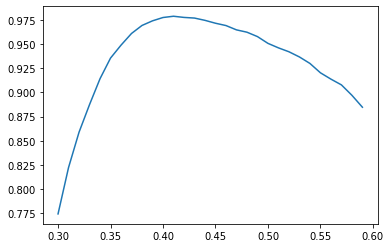

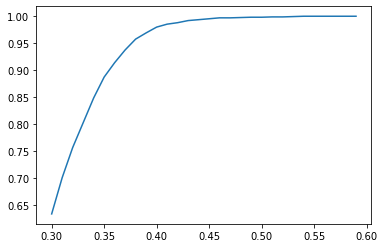

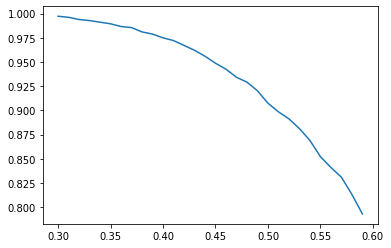

In [12]:
off_diag = var[np.triu_indices(p, k=1)]

threshold_list = np.arange(0.3, 0.6, 0.01)
F1_score_2 = []
precision_list_2 = []
recall_list_2 = [] 


for thres in threshold_list:
    ## Threshold the small entries of var_obs
    var_off_diag_thres = copy.copy(var_off_diag)
    var_off_diag_thres[np.abs(var_off_diag_thres)<=thres] = 0
    
    positive_index = (np.abs(off_diag)>0)*1
    predict_positive_index = (np.abs(var_off_diag_thres)>0)*1
    fn = np.sum(positive_index*(1-predict_positive_index))
    tp = np.sum(predict_positive_index*positive_index)
    precision = tp/np.sum(predict_positive_index)
    recall = tp/(tp+fn)
    
    ## Deviation from the true covariance matrix
    F1_score_2 += [2*precision*recall/(precision+recall)]
    precision_list_2 += [precision]
    recall_list_2 += [recall]

max_F1 = np.max(F1_score_2)
print(max_F1)
plt.plot(threshold_list, F1_score_2)
plt.show()

plt.plot(threshold_list, precision_list_2)
plt.show()

plt.plot(threshold_list, recall_list_2)
plt.show()

In [11]:
## Randomly guess the non-zero covariance entries
## Approach: randomly reorganize the entries 
# order = 
# var_random = copy.copy(var_obs)


# plt.plot(threshold_list, F1_score, label = 'From CMS')
# plt.plot(threshold_list, F1_score_2, label = 'From Sample Covariance')
# plt.xlabel('Thresholds')
# plt.ylabel('F1 Score')
# plt.legend()
# plt.show()